In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")

# then move to feature extraction
os.chdir("feature_extraction")

print(os.getcwd())

/home/ra/Codes/timescales_filtering/feature_extraction


In [4]:
from utils import load_story_info
from hard_coded_things import featuresets_dict, train_stories, test_stories

import numpy as np

from typing import Dict, List

from tqdm.notebook import trange, tqdm
from typing import Optional
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
import seaborn as sns

from signal_processing import compute_psd, upsample_story
from utils import get_dir

Using gpu


In [5]:
from config import config_plotting

In [6]:
config_plotting(context="paper", palette="muted")

In [39]:
fft_size = 1024
sr = 10

upsampling_method = "linear"
normalized_psd = True

is_chinese=False

aggregation_method = 'mean'

cache = ".cache/spectral_analysis/en"

In [8]:
if not os.path.exists(cache):
    os.makedirs(cache)

In [9]:
all_stories = train_stories + test_stories

# Upsampling Stories

In [10]:
grid_dir, trfile_dir = get_dir(is_chinese=False)

In [17]:

story_data_bert_en= {}
for s in all_stories:
    story_data_bert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="BERT_all",
        cache=cache
    )

In [18]:
story_data_mbert_en= {}
for s in all_stories:
    story_data_mbert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="mBERT_all",
        cache=cache
    )

# Spectral Density Analysis

In [40]:
def compute_psd_per_channel(story_data: dict, story_list: List = train_stories):
    n_neurons = story_data_bert_en[train_stories[0]]['story_data'].shape[1]
    psds = np.zeros((n_neurons, fft_size // 2 + 1))
    f = None
    for n in trange(n_neurons):
        # join for all stories
        joint_data = np.concatenate([story_data[s]['story_data'][:, n] for s in story_list])
        # compute periodogram
        f, psds[n] = welch(joint_data, fs=sr, nperseg=fft_size, return_onesided=True)
        # f, psds[n] = periodogram(joint_data, fs=sr, nfft=fft_size)
        
    return f, psds

In [41]:
f, bert_periodograms = compute_psd_per_channel(story_data_bert_en, story_list = train_stories)
f, mbert_periodograms = compute_psd_per_channel(story_data_mbert_en, story_list = train_stories)

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

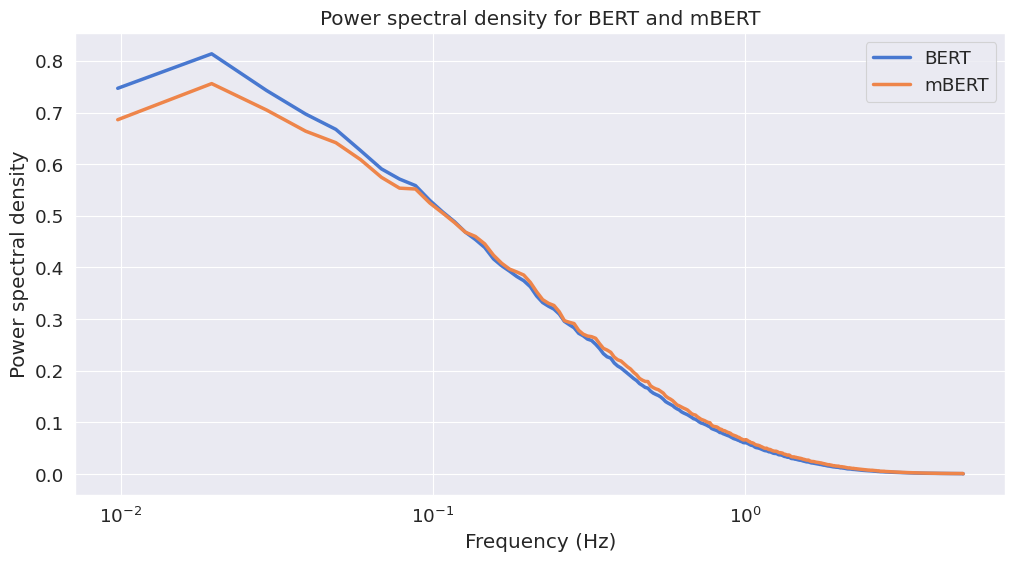

In [42]:
# plot PSDs for BERT and mBERT 
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.mean(bert_periodograms, axis=0)[1:], label="BERT")
plt.plot(f[1:], np.mean(mbert_periodograms, axis=0)[1:], label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title("Power spectral density for BERT and mBERT")

# log scale
plt.xscale("log")

plt.legend()
plt.show()
        

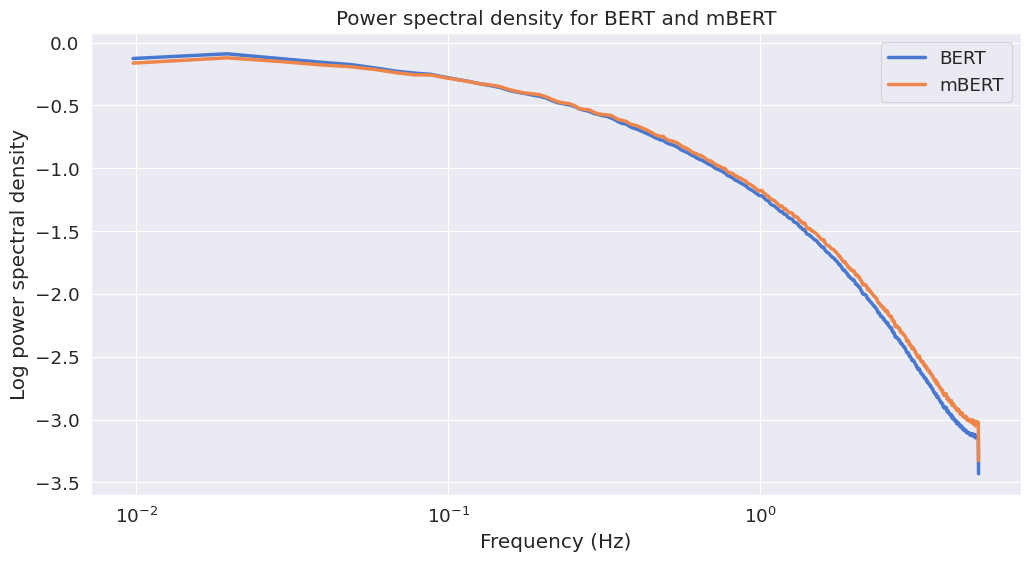

In [59]:
# plot PSDs for BERT and mBERT in dB scale
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.log10(np.mean(bert_periodograms, axis=0)[1:]), label="BERT")
plt.plot(f[1:], np.log10(np.mean(mbert_periodograms, axis=0)[1:]), label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Log power spectral density")

plt.title("Power spectral density for BERT and mBERT")

# log scale
plt.xscale("log")

plt.legend()

plt.show()


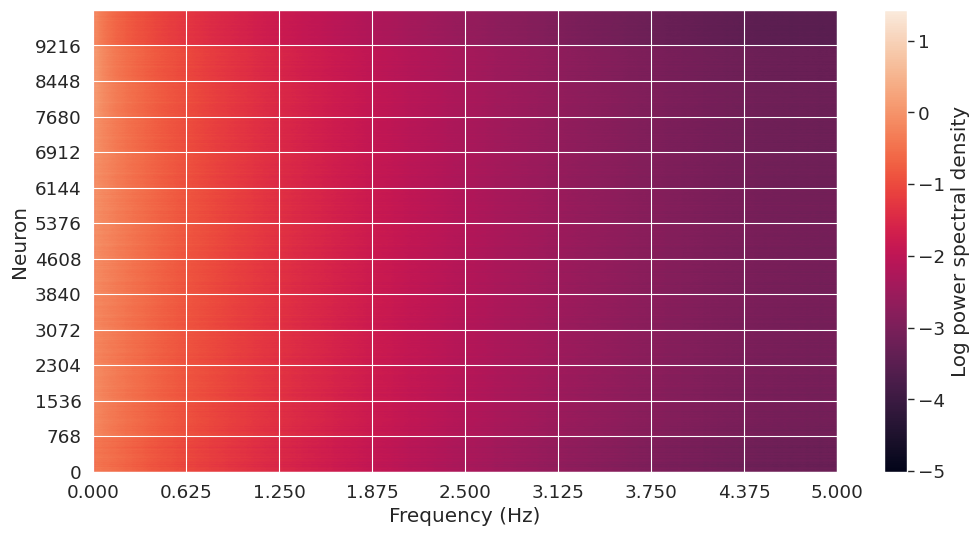

In [60]:
# plot psd imshow for BERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(bert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, bert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

# add colorbar
plt.colorbar(label="Log power spectral density")


plt.show()

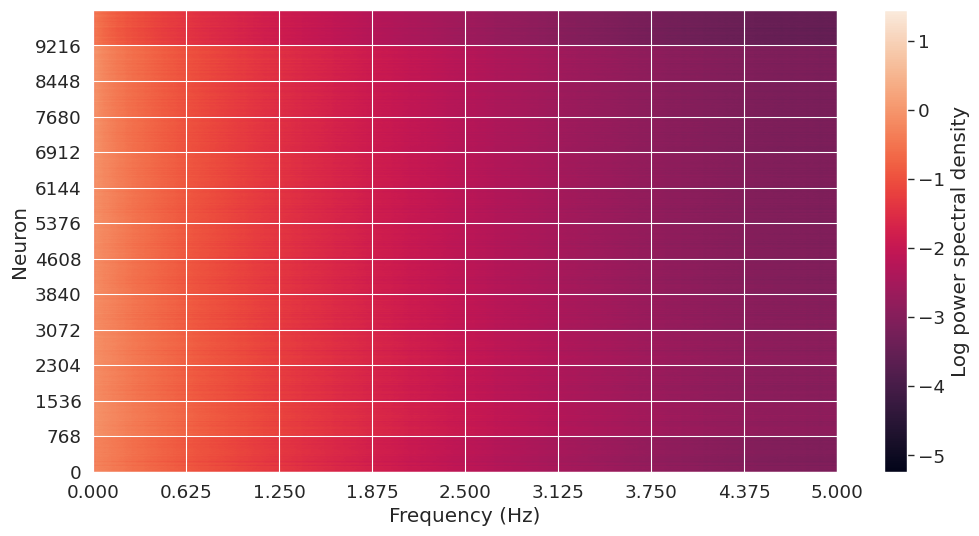

In [61]:
# now for mBERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(mbert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, mbert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

plt.colorbar(label="Log power spectral density")


plt.show()

# Construct timescale feature

In [63]:
from filtering import LowPassFilter, HighPassFilter, BandPassFilter
from save_features import get_bandpass_values

In [64]:
fc_values, bandwidth_values = get_bandpass_values()  # [num_bands], [num_bands]


In [67]:
fc_values

[0.375,
 0.1875,
 0.09375,
 0.046875,
 0.0234375,
 0.01171875,
 0.005859375,
 0.00390625]

In [ ]:
for fc, bandwidth in zip(fc_values, bandwidth_values):
    fir = "bandpass"
    if use_lowpass and np.allclose(fc, lowpass_fc, atol=epsilon):
        fir = "lowpass"
    if use_highpass and np.allclose(fc, highpass_fc, atol=epsilon):
        fir = "highpass"
    print(f"Using {fir} filter for fc={fc}, bandwidth={bandwidth}")